In [1]:
%matplotlib inline
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from PIL import Image
import glob,cv2,os,natsort,math,time
import import_ipynb
from simulator import obj as actual_obj
import sys
from skimage import color, io

importing Jupyter notebook from simulator.ipynb


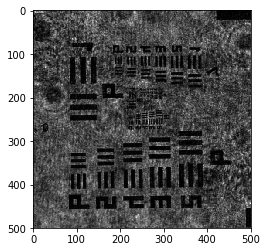

In [2]:
### USE CALIBRATED DATA ###
# If using calibrated data, comment out 'SIMULATED DATA' section
f = h5py.File(r'C:\Users\Grant\Documents\Internships_Research\Waller_Lab\waller\Regina_data\first_seq_924_1051_selfCal.mat','r')
images = f.get('data')
images = np.array(images)
plt.imshow(images[60],cmap='gray')

### USE SIMULATED DATA ###
# If using simulated data, comment out 'CALIBRATED DATA' section
#base_dir = r'C:\Users\Grant\Documents\Internships_Research\Waller_Lab\scripts\simulated_images\regina_sample_data'
#
#def load_data(directory):
#    images3D = []
#    for filepath in glob.iglob(directory+r'\*.png'):
#        images3D.append(color.rgb2gray(io.imread(filepath)))
#    
#    return images3D
#images = load_data(base_dir)

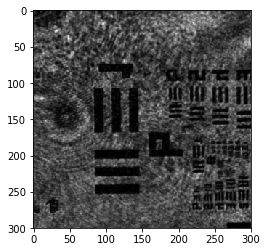

In [28]:
### Crop images ###

# returns set of cropped numpy images

def crop_center(img,cropx1,cropx2,cropy1,cropy2): # 'img': set of numpy images
                                                  #'cropx1','cropx2','cropy1','cropy2': set crop dimensions
    cropped_images = []
    counter = 0
    for i in img:
        cropped_images.append(i[cropy1:cropy2,cropx1:cropx2])
        matplotlib.image.imsave(r'C:\Users\Grant\Documents\Internships_Research\Waller_Lab\waller\Grant_data\seq_init_crop\image_'\
                                +str(counter)+'.png', cropped_images[counter], cmap='gray')
        counter += 1  
        print('Cropped',counter,'images', end="\r")
        time.sleep(0.001)
        
    return cropped_images

#cropped = (crop_center(images,100,400,100,400)) CHANGE
cropped = (crop_center(images,0,300,0,300))

plt.imshow(cropped[62],cmap='gray')

In [29]:
### Define variables here ###

lamb = 0.532  # um, wavelength of illumination, assume monochromatic
dpix_c = 2.4 # um, pixel size onthe sensor plane, PCO = 6.5um
NA_objective = 0.45    # numerical aperture of objective
mag = 10     # magnification of the system

'\n### SIMULATED DATA ###\n# If using simulated data, comment out \'calibrated DATA\' section\nmax_NA = 0.35\nr_led = 7 #radius, in unit of "# of leds"\n[NA_x, NA_y] = np.meshgrid(np.linspace(-max_NA, max_NA, 2*r_led+1), np.linspace(-max_NA, max_NA, 2*r_led+1))\nNA_x[np.arange(1, NA_x.shape[0], 2), :] = NA_x[np.arange(1, NA_x.shape[0], 2), ::-1] #Flip every other column\n#Limit down to a circle\nvalid_led = (NA_x**2+NA_y**2) <= (max_NA**2)\nNA_y = NA_y[valid_led]\nNA_x = NA_x[valid_led]\n\nangleD_x = np.arcsin(NA_x)*180/np.pi\nangleD_y = np.arcsin(NA_y)*180/np.pi\n\nnumber_images = 149\n'

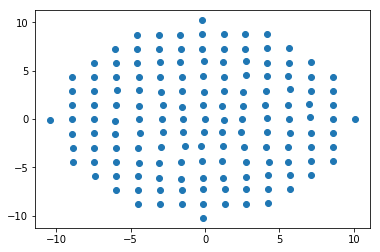

In [30]:
### Angles of illumination ###

### CALIBRATED DATA ###
# If using calibrated data, comment out 'SIMULATED DATA' section
max_NA = 0.65

#freqUV_cal = np.array(f.get('freqUV_cal'))*lamb # from Regina already calibrated data
freqUV_cal = np.array(f.get('metadata/source_list/na_init'))*lamb # REMEMBER: USE FORWARD SLASH ('/')
NA_x,NA_y = freqUV_cal[0],freqUV_cal[1]

#Limit down to a circle
valid_led = (NA_x**2+NA_y**2) <= (max_NA**2)

NA_x = NA_x[valid_led]
NA_y = NA_y[valid_led]

angleD_x = np.arcsin(NA_x)*180/np.pi
angleD_y = np.arcsin(NA_y)*180/np.pi

plt.plot(angleD_x,angleD_y,'o')

'''
### SIMULATED DATA ###
# If using simulated data, comment out 'calibrated DATA' section
max_NA = 0.35
r_led = 7 #radius, in unit of "# of leds"
[NA_x, NA_y] = np.meshgrid(np.linspace(-max_NA, max_NA, 2*r_led+1), np.linspace(-max_NA, max_NA, 2*r_led+1))
NA_x[np.arange(1, NA_x.shape[0], 2), :] = NA_x[np.arange(1, NA_x.shape[0], 2), ::-1] #Flip every other column
#Limit down to a circle
valid_led = (NA_x**2+NA_y**2) <= (max_NA**2)
NA_y = NA_y[valid_led]
NA_x = NA_x[valid_led]

angleD_x = np.arcsin(NA_x)*180/np.pi
angleD_y = np.arcsin(NA_y)*180/np.pi

number_images = 149
'''

In [ ]:
freqUV_design = [angleD_x,angleD_y]
freqUV_design = np.array(freqUV_design)

I = cropped
print(I[60])

[[ 8511.  8795.  7946. ... 11172. 12737. 11213.]
 [ 9339. 10788. 13059. ... 11595. 14402. 13887.]
 [12920. 14501. 15913. ... 11714. 13253. 13309.]
 ...
 [ 7452.  8315.  8774. ...  1607.  1208.  1300.]
 [ 7523.  7148.  7401. ...  1375.  1175.   772.]
 [ 8438.  7476.  6990. ...   890.   614.   634.]]


In [ ]:
### Subtract Background ###

# To use: Run code and double-click on image to pick vertex. To confirm selection, press 'a'.
# Each pair of double-clicks mark opposite vertices of patch. After four selections,
# image will close. Press 'esc' at any time to exit.

# CURRENTLY DOING EVERYTHING W/ data in 'Regina_data' folder

Imms = [f for f in glob.glob(r'C:\Users\Grant\Documents\Internships_Research'+\
                          '\Waller_Lab\waller\Grant_data\seq_init_crop\*.png',\
                          recursive=True)]

ix,iy = -1,-1
def return_pos(event,x,y,flags,param):
    global ix,iy
    if event == cv2.EVENT_LBUTTONDBLCLK:
        ix,iy = x,y

def read_cropped(img_path):
    img = cv2.imread(img_path,0)
    cv2.namedWindow('image')
    cv2.setMouseCallback('image', return_pos)
    recs = []
    counter = 0
    while(counter < 4):
        cv2.imshow('image',img)
        k = cv2.waitKey(20)
        if k == 27:                   # to terminate: ASCII 27 is 'esc'.
            break
        elif k == ord('a'):           # PRESS a to confirm vertex selections.
            recs.append([ix,iy])
            counter += 1
    cv2.destroyAllWindows()
    
    return(recs)                      # returns opposite vertices of both rectangles (top left and bottom right).

def select_recs(vert,img):       # creates rectangles out of vertices selections.
    rec_1_v = np.array(vert[0:2])
    rec_2_v = np.array(vert[2:4])
    rec_1_v = np.reshape(rec_1_v,(2,2))
    rec_2_v = np.reshape(rec_2_v,(2,2))

    crop_img_1 = img[rec_1_v[0][0]:rec_1_v[1][0], rec_1_v[0][1]:rec_1_v[1][1]]
    crop_img_2 = img[rec_2_v[0][0]:rec_2_v[1][0], rec_2_v[0][1]:rec_2_v[1][1]]
    return(np.mean(crop_img_1),np.mean(crop_img_2))

def folder_size(path):               # returns size of folder
    total = 0
    for entry in os.scandir(path):
        if entry.is_file():
            total += 1
    return total

#seq0_size = folder_size(r'C:\Users\Grant\Documents\Internships_Research\Waller_Lab\waller\Grant_data\seq_init_crop')
vertices = read_cropped(Imms[60])        # choose I[0] just as a sample, can be any image in the seq0_crop directory

thresh = 10                           # background threshold
means_1 = []                          # creates list of means for first rectangles in all images in seq0_crop directory
means_2 = []                          # creates list of means for second rectangles
for i in range(len(I)):
    y = select_recs(vertices, I[i])
    means_1.append(y[0])
    means_2.append(y[1])

means_1 = np.array(means_1)
means_2 = np.array(means_2)
mean_bg = np.mean((means_1,means_2), axis = 0) # average of both rectangles by column

if mean_bg[0] > thresh:                # if first image mean is above threshold, set the first index as the threshold
    mean_bg[0] = thresh
for i in range(len(mean_bg))[1:]:      # for each image mean, if it is above the threshold, set it to the previous mean value
    if mean_bg[i] > thresh:
        mean_bg[i] = mean_bg[i-1]


for i in range(len(I)):             # create noise image for each image and subtract, low-pass filter
    x = np.zeros((300,300))
    x = [mean_bg[i] for j in x]
    new_img = I[i] - x
    matplotlib.image.imsave(r'C:\Users\Grant\Documents\Internships_Research\Waller_Lab\waller\Regina_data\cropped_image_'\
                                +str(i)+'.png', new_img, cmap='gray')
    

In [ ]:
# sort everything

NAs_list = np.sqrt((NA_x**2)+(NA_y**2))                        # Create absolute values of NAs
I_bkg = [f for f in glob.glob(r'C:\Users\Grant\Documents\Internships_Research\Waller_Lab\waller\Regina_data\*.png',\
                          recursive=True)]                     # list of images in the sequence
I_sorted = natsort.natsorted(I_bkg)                            # Sort list by integer ('0,1,2,...' not '1,10,100,2,20,...')
I_na_freqUV = []
for i in range(len(I_bkg)):
    I_na_freqUV.append([I_sorted[i],NAs_list[i],\
                        [freqUV_design[0],freqUV_design[1]]])  # Create list of images with corresponding NAs and angles

I_na_freqUV.sort(key=lambda x: x[1])                           # Sort this list smallest to largest according to NAs

images = [I_na_freqUV[i][0] for i in range(len(I_na_freqUV))]  # seperate list into (now ordered by NA) image files, \
NA_A = [I_na_freqUV[i][1] for i in range(len(I_na_freqUV))]    # NA, and angles
angles = [I_na_freqUV[i][2] for i in range(len(I_na_freqUV))]
images = np.array(images)
NA_freqUV = np.array(NA_A)
angles = np.array(angles)


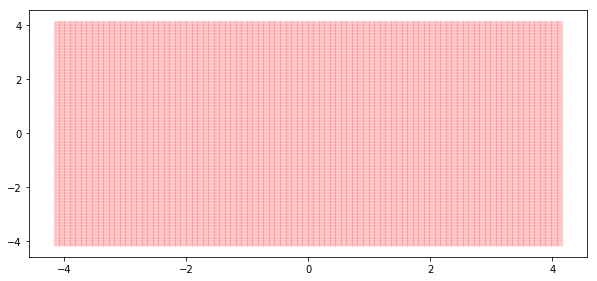

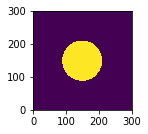

In [ ]:
### DEFINE SYSTEM ###

NsampR = np.shape(cropped[0]) # return size of cropped images
NsampR = np.array(NsampR)
z = np.zeros(NsampR)
ci,cj = round(len(z)/2),round(len(z[0])/2)
cr=round(len(z)/4)
I,J = np.meshgrid(np.arange(z.shape[0]),np.arange(z.shape[1]))
dist = np.sqrt((I-ci)**2+(J-cj)**2)
z[np.where(dist<cr)]=1

n_r = 1

NsampR = np.shape(cropped[0]) # return size of cropped images
NsampR = np.array(NsampR)

uMax = NA_objective/lamb  # Maximum spatial frequency set by NA (1/um)
dxNA = (1/uMax)/2         # System resolution based on the NA (um)
dpix_m = dpix_c/mag       # Effective image pixel size on the object plane (um)
FoV = NsampR*dpix_m       # FoV in the object space

# Sample size in Fourier plane (set by image size (FoV))
du = np.zeros(2)
if NsampR[0] % 2 == 1:   # ROWS
    du[0] = 1/dpix_m/(NsampR[0]-1)
else:
    du[0] = 1/FoV[0]     # sampling size at Fourier plane is always 1/FoV
if NsampR[1] % 2 == 1:   # COLUMNS
    du[1] = 1/dpix_m/(NsampR[1]-1)
else:
    du[1] = 1/FoV[1]

um_idx = uMax/du # max spatial freq/sample size at Fourier plane = # of samples in Fourier space (?). \
                 # I think pixels at Fourier plane?

empty_grid = np.zeros(NsampR) # Create grid size of images

# Maximum spatial frequency achievable based on the maximum illumination
# angle (NAs from NA_freqUV) from the LED array and NA of the objective
um_p = (max(NA_freqUV[:])/lamb) + uMax
# Resolution achieved after frequency post-processing
dx0_p = (1/um_p)/2

# Assume the max spatial frequency of the original object
# um_obj > um_p
# Assume the number of pixels of the original object
# upsample by 2 for intensity (Ask Regina for reason why again)
N_obj = np.around((um_p/du)*2*2) # solving for the number of samples in freq space 

# need to enforce N_obj/Np = integer to ensure no FT artifacts
multiplier = (np.around((N_obj/NsampR)))


### REVISE LATER MULTIPLIER
multiplier = np.array([2,2]) # MULTIPLY BY MINIMUM 2, goal to create larger reconstructed object
N_obj = multiplier*NsampR



# max spatial freq of the original object
um_obj = (du*N_obj/2)

# sampling size of the object (= pixel size of the test image)
dx_obj = (1/um_obj)/2

# setup grid ranges
xxo = (np.arange((-N_obj[1]/2),(N_obj[1]/2)))*dx_obj[1] ### RECONSTRUCTED IMAGE OF OBJECT IN OBJECT PLANE
yyo = (np.arange((-N_obj[0]/2),(N_obj[0]/2)))*dx_obj[0]
xxi = (np.arange((-NsampR[1]/2),(NsampR[1]/2)))*dpix_m  ### IMAGE OF OBJECT IN OBJECT PLANE
yyi = (np.arange((-NsampR[0]/2),(NsampR[0]/2)))*dpix_m
uuo = (np.arange((-N_obj[1]/2),(N_obj[1]/2)))*du[1]
vvo = (np.arange((-N_obj[0]/2),(N_obj[0]/2)))*du[0]
uui = (np.arange((-NsampR[1]/2),(NsampR[1]/2)))*du[1]
vvi = (np.arange((-NsampR[0]/2),(NsampR[0]/2)))*du[0]

# spatial coordinates for object space
xso,yso = np.meshgrid(xxo,yyo)
# spatial coordinates for image space
xsi,ysi = np.meshgrid(xxi,yyi)
dx_img=dpix_m; #sampling size in image (demagnified pixel)

# spatial frequency coordinates for object space
ufo,vfo = np.meshgrid(uuo,vvo)
# spatial frequency coordinates for image space
ufi,vfi = np.meshgrid(uui,vvi)

# Define k-space for these coordinates
ko = np.pi*lamb*(ufo**2+vfo**2)/n_r
ki = np.pi*lamb*(ufi**2+vfi**2)/n_r

# Plot grid to visualize
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(211)
ax.plot(ufo,vfo,marker='.', markersize=0.05, color='r', linestyle='none')
plt.show()

# Generate pupil function
ci,cj = round(len(z)/2),round(len(z[0])/2)
cr=uMax/du[1]
dist = np.sqrt(ufi**2+vfi**2)
pupil = dist < uMax

# PLot pupil function
fig=plt.figure()
ax=fig.add_subplot(221)
ax.pcolormesh(pupil)
ax.set_aspect('equal')
plt.show()



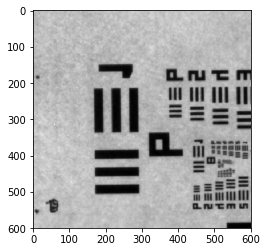

In [ ]:
# Create images filled with the means of each image for ptych initial guesses
mean_ims = np.average(cropped,axis=0)
mean_ims_rsize = cv2.resize(mean_ims,(600,600))
plt.imshow(mean_ims_rsize,cmap='gray')

In [ ]:
### PTYCHOGRAPHY RECONSTRUCTION ###

# Create images filled with the means of each image for ptych initial guesses
mean_ims = np.average(cropped,axis=0)
mean_ims_rsize = cv2.resize(mean_ims,(600,600))

tol = 1
OP_alpha = 10               #OP_alpha: regularization parameter for Object
OP_beta = 1                 #OP_beta: regularization parameter for Pupil

Ps = pupil
x_obj = xso
y_obj = yso
dpix_mF = (dpix_c/mag)*NsampR[0]/N_obj[0] # Pixel size of new image at sample plane
con=NsampR[0]*dpix_c/mag #Conversion factor (pixels/(1/um)) # FOV
I = cropped

cen0 = np.around((N_obj+1)/2) # Center of reconstructed object

# Initialization

#Fourier & Inverse Fourier Transforms
def F(x):
#    return np.fft.ifftshift(np.fft.fft2(np.fft.fftshift(x)))
    return np.fft.fft2(x)
def Ft(x):
#    return np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(x)))
    return np.fft.ifft2(x)

maxIter = 50

O0 = np.array(mean_ims_rsize)
Pup = pupil
objR = O0 # Initial reconstructed guess
ObjF = F(objR) # Initial reconstructed guess in Fourier Space
objRsave=np.zeros((maxIter,np.shape(objR)[0],np.shape(objR)[1]),dtype=complex)

err1 = math.inf
err2 = 50
err = np.zeros(maxIter)
iter = 0

### MAIN ###

# stopping criteria: when relative change in error falls below some value,
# can change this value to speed up the process by using a larger value but
# will trade off the reconstruction accuracy.
# error is defined by the difference between the measurement and the estimated
# images in each iteration.

# Convert from 1/um center to corresponding crop region
# **** Check this conversion
Pupilshifty = np.around(np.array(NA_y)*con) # Converts freq space to # of pixels G
Pupilshiftx = np.around(np.array(NA_x)*con)

# Corresponding crop regions
YXmid = np.floor(N_obj/2)+1
hfSz = np.floor(NsampR[0]/2)
Nimg = len(cropped) # Number of images
cropR = np.zeros((Nimg,4))
cropR[:,0] = YXmid[0] + Pupilshifty - hfSz     # y start
cropR[:,1] = YXmid[0] + Pupilshifty + hfSz - 1 # y end
cropR[:,2] = YXmid[1] + Pupilshiftx - hfSz     # x start
cropR[:,3] = YXmid[1] + Pupilshiftx + hfSz - 1 # x end

# Corresponding to freqUV = (0,0)
cropR_00 = np.array([YXmid[0] - hfSz,     # y start \
                    YXmid[0] + hfSz - 1,  # y end \
                    YXmid[1] - hfSz,      # x start \
                    YXmid[1] + hfSz - 1]) # x end

Objcrop = np.zeros((Nimg, NsampR[0], NsampR[1]),dtype=complex)

now = time.time()
while abs(err1-err2)>tol and iter<maxIter:
    err1 = err2
    err2 = 0
    iter+=1
    
    for i in range(Nimg):
        # Print current image number
        #print('Evaluating image = %s' % str(i))

        I_mea = I[i]
        
        # Perform correction on object reconstruction AND pupil function
        eps = 2.2204460492503131e-16
        row_ind = range(int(cropR[i,0]),int(cropR[i,1])+1)
        col_ind = range(int(cropR[i,2]),int(cropR[i,3])+1)
        Objfcrop = ObjF[np.ix_(row_ind,col_ind)]                                        # Crop out portion of object reconstruction
        ObjfcropP = Objfcrop*Pup                                                        # Apply pupil function
        ObjcropP = Ft(ObjfcropP)           # Exit freq. domain
        Objfup = F((np.sqrt(I_mea))*ObjcropP/((np.abs(ObjcropP+eps)))) # Apply phase (e^(jPHI)) to image (freq. domain)
    
        # Update reconstruction guess and pupil function (gradient descent)
        ObjF[np.ix_(row_ind,col_ind)] = ObjF[np.ix_(row_ind,col_ind)] + ((np.abs(Pup))*(np.conj(Pup))*(Objfup-ObjfcropP)/\
                                                                         ((np.max(np.abs(Pup)))*((np.abs(Pup))**2+OP_alpha)))
        Pup = Pup + ((np.abs(Objfcrop))*(np.conj(Objfcrop))*(Objfup-ObjfcropP)*Ps/\
                     ((np.max(np.abs(ObjF)))*((np.abs(Objfcrop))**2+OP_beta)))
        
        Objcrop[i,:,:] = Ft(ObjF[np.ix_(row_ind,col_ind)]*Pup)
        
    print('\n')

    objR = Ft(ObjF)
    objRsave[iter-1,:,:] = objR

    ### COMPUTE ERROR ###
    # Record the error and check convergence later
    err[iter-1] = np.sum((I-(np.abs(Objcrop))**2)**2) # squared error; recall from EE120 Lab 5
    err2 = err[iter-1]
    
    st_iter = str(iter)
    st_err2 = str(err2)
    output = '| %s | %s |'
    print((output % (st_iter,st_err2)),'\n')
    
elapsed = time.time() - now
print('Time elapsed:', elapsed, 'seconds')



| 1 | 387053763536722.0 | 



| 2 | 368023226645315.75 | 



| 3 | 363544325478257.25 | 



| 4 | 361187448105809.2 | 



| 5 | 359779233481974.94 | 



| 6 | 358659709147559.8 | 



| 7 | 357725653513147.8 | 



| 8 | 357060967863879.7 | 



| 9 | 356587423619401.6 | 



| 10 | 356120190760639.0 | 



| 11 | 355720552211545.7 | 



| 12 | 355341439569087.75 | 



| 13 | 355065466055559.6 | 



| 14 | 354874244747019.9 | 



| 15 | 354778103096402.2 | 



| 16 | 354624993224598.5 | 



| 17 | 354428487741175.3 | 



| 18 | 354092532378980.94 | 



| 19 | 353785737560835.8 | 



| 20 | 353480491401113.5 | 



| 21 | 353088944420263.44 | 



| 22 | 352737762923712.44 | 



| 23 | 352445838492561.0 | 



| 24 | 352227163113408.56 | 



| 25 | 351990753654772.25 | 



| 26 | 351654292904232.2 | 



| 27 | 351346987111104.2 | 



| 28 | 351036412112527.5 | 



| 29 | 350718112167664.4 | 



| 30 | 350446897744125.1 | 



| 31 | 350174149771059.6 | 



| 32 | 349948290440373.2 | 



| 33 |

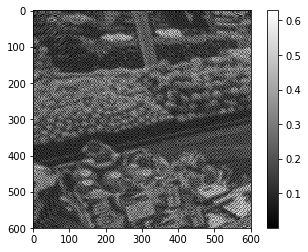

In [12]:
plt.imshow(np.abs(objR),cmap='gray')
plt.imsave('objR_amplitude',np.abs(objR),cmap='gray')
plt.colorbar()

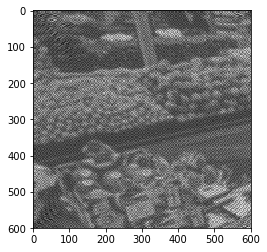

In [13]:
plt.imshow(np.real(objR),cmap='gray')

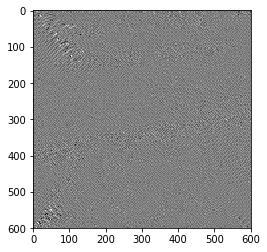

In [14]:
plt.imshow(np.angle(objR),cmap='gray')
plt.imsave('objR_phase',np.angle(objR),cmap='gray')

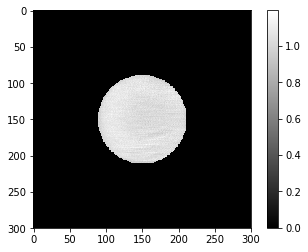

In [15]:
plt.imshow(np.abs(Pup),cmap='gray')
plt.imsave('Pupil',np.abs(Pup),cmap='gray')
plt.colorbar()